In [ ]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

# Setup file path
base_path = r"D:\Tourism_Experience_Analytics"
output_path = os.path.join(base_path, "test123.csv")

# Load Excel files
city = pd.read_excel(os.path.join(base_path, "City.xlsx"))
country = pd.read_excel(os.path.join(base_path, "Country.xlsx"))
region = pd.read_excel(os.path.join(base_path, "Region.xlsx"))
continent = pd.read_excel(os.path.join(base_path, "Continent.xlsx"))
attraction = pd.read_excel(os.path.join(base_path, "Item.xlsx"))
attraction_type = pd.read_excel(os.path.join(base_path, "Type.xlsx"))
visit_mode = pd.read_excel(os.path.join(base_path, "Mode.xlsx"))
transaction = pd.read_excel(os.path.join(base_path, "Transaction.xlsx"))
user = pd.read_excel(os.path.join(base_path, "User.xlsx"))

# Data Cleaning
transaction.dropna(subset=["UserId", "AttractionId", "VisitMode"], inplace=True)
user.dropna(subset=["UserId", "CityId"], inplace=True)
city.dropna(subset=["CityId", "CityName"], inplace=True)

visit_mode["VisitMode"] = visit_mode["VisitMode"].astype(str).str.strip().str.title()
transaction["VisitMode"] = transaction["VisitMode"].astype(str).str.strip().str.title()
attraction_type["AttractionType"] = attraction_type["AttractionType"].str.strip().str.title()

if "VisitYear" in transaction.columns and "VisitMonth" in transaction.columns:
    transaction["VisitDate"] = pd.to_datetime(
        transaction["VisitYear"].astype(str) + "-" + transaction["VisitMonth"].astype(str).str.zfill(2),
        errors='coerce'
    )

if "Rating" in transaction.columns:
    transaction = transaction[(transaction["Rating"] >= 1) & (transaction["Rating"] <= 5)]

# Merge hierarchy: City > Country > Region > Continent
city_country = pd.merge(city, country, on="CountryId", how="left")
city_country_region = pd.merge(city_country, region, on="RegionId", how="left")
city_hierarchy = pd.merge(city_country_region, continent, on="ContinentId", how="left")
print("City hierarchy merged:", city_hierarchy.shape)

# Attraction + Type
attraction_full = pd.merge(attraction, attraction_type, on="AttractionTypeId", how="left")
print("Attraction + Type merged:", attraction_full.shape)

# Transaction + Attraction
txn_attraction = pd.merge(transaction, attraction_full, on="AttractionId", how="left")
print("Transaction + Attraction merged:", txn_attraction.shape)

# Add Visit Mode
txn_with_mode = pd.merge(txn_attraction, visit_mode, on="VisitMode", how="left")
print("Transaction + Visit Mode merged:", txn_with_mode.shape)

# Prepare user data (rename to avoid column conflicts)
user_renamed = user.rename(columns={
    "CountryId": "User_CountryId",
    "RegionId": "User_RegionId",
    "ContinentId": "User_ContinentId"
})

# Add user info
final = pd.merge(txn_with_mode, user_renamed, on="UserId", how="left")
print("Added User Info:", final.shape)

# Add city hierarchy
final = pd.merge(final, city_hierarchy, on="CityId", how="left")
print("Added City Hierarchy:", final.shape)

# Remove duplicates
final = final.loc[:, ~final.columns.duplicated()]

# Drop rows with missing critical info post-merge
final.dropna(subset=["UserId", "AttractionId", "VisitMode", "Rating", "AttractionType"], inplace=True)
print("After dropping rows with missing critical info:", final.shape)

# Feature Encoding
encode_cols = ["VisitMode", "Continent", "CountryName", "AttractionType"]
for col in encode_cols:
    if col in final.columns:
        le = LabelEncoder()
        final[col + "_Encoded"] = le.fit_transform(final[col].astype(str))
    else:
        print(f"Skipped encoding: {col} not found.")

# User-level aggregation: Avg rating per mode
if "VisitMode" in final.columns and "Rating" in final.columns:
    user_profiles = (
        final.groupby(["UserId", "VisitMode"])["Rating"]
        .mean()
        .reset_index()
        .rename(columns={"Rating": "AvgRatingPerMode"})
    )
    final = pd.merge(final, user_profiles, on=["UserId", "VisitMode"], how="left")

# Normalize Rating and AvgRatingPerMode safely
scaler = MinMaxScaler()
if "Rating" in final.columns and not final["Rating"].empty:
    final["Rating_Scaled"] = scaler.fit_transform(final[["Rating"]])

if "AvgRatingPerMode" in final.columns and not final["AvgRatingPerMode"].isnull().all():
    final["AvgRatingPerMode_Scaled"] = scaler.fit_transform(final[["AvgRatingPerMode"]])
else:
    print("AvgRatingPerMode column empty or missing — skipped scaling.")

# Drop irrelevant/noisy columns
columns_to_drop = [
    'ContinentId', 'Rating', 'CountryId', 'User_RegionId', 'AttractionTypeId',
    'RegionId', 'CityId', 'VisitModeId', 'AttractionAddress', 'TransactionId',
    'CityName', 'CountryName', 'Region', 'Attraction'
]

final_cleaned = final.drop(columns=[col for col in columns_to_drop if col in final.columns])

# Drop rows with any NaNs (8 rows only)
final_cleaned = final_cleaned.dropna()


# Save the cleaned dataset
final_cleaned.to_csv(output_path, index=False)
print("Final dataset saved:", output_path)
print("Final dataset shape:", final_cleaned.shape)


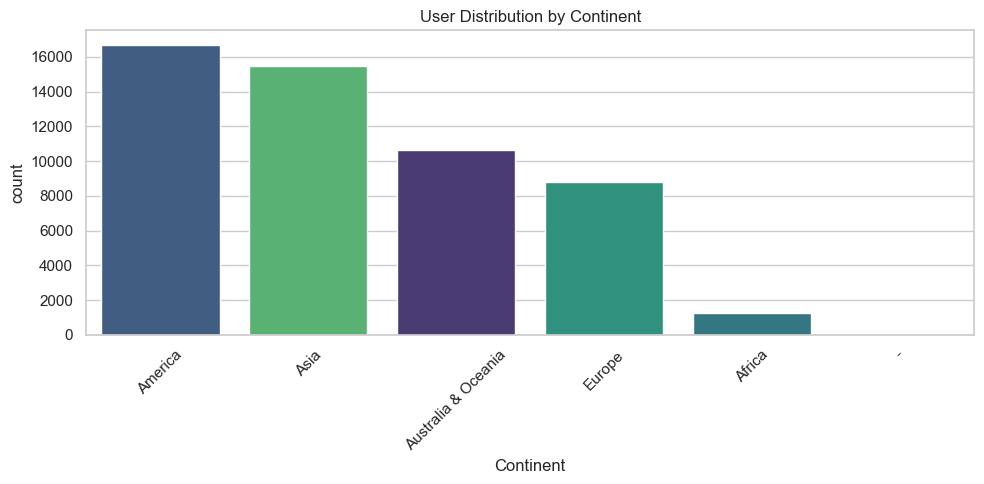

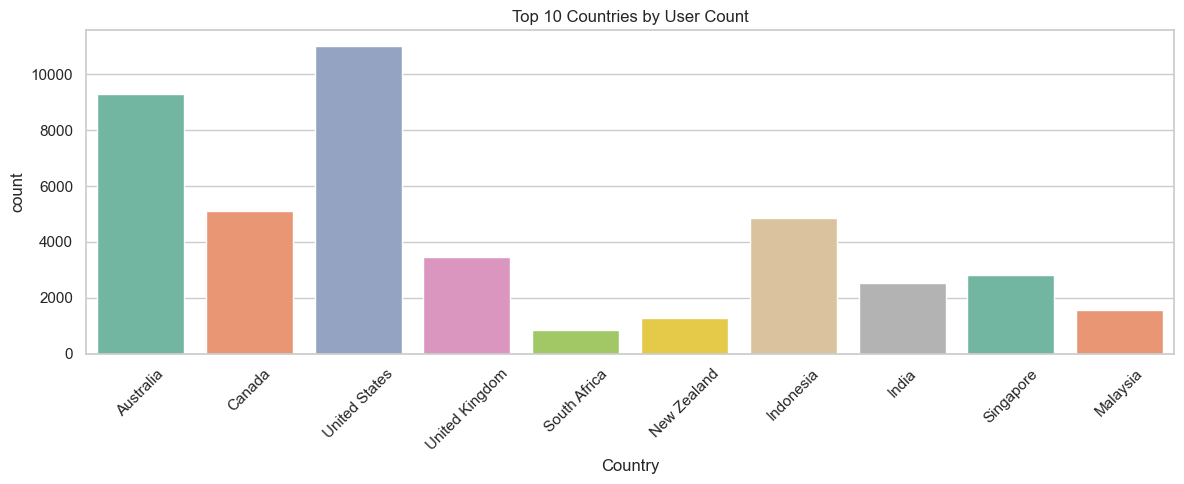

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(r"D:\Tourism_Experience_Analytics\test123.csv")

# Replace VisitMode numbers with descriptive labels
visit_mode_mapping = {
    1: 'Business',
    2: 'Couples',
    3: 'Family',
    4: 'Friends',
    5: 'Solo'
}
df['VisitMode_Label'] = df['VisitMode'].map(visit_mode_mapping)

# Set Seaborn style
sns.set(style='whitegrid')

# 1. User distribution by continent
plt.figure(figsize=(10, 5))
sns.countplot(data=df, x='Continent', hue='Continent', order=df['Continent'].value_counts().index, palette='viridis', legend=False)
plt.title('User Distribution by Continent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# 1b. Top countries by user count
plt.figure(figsize=(12, 5))
top_countries = df['Country'].value_counts().head(10).index
sns.countplot(data=df[df['Country'].isin(top_countries)], x='Country', hue='Country', palette='Set2', legend=False)
plt.title('Top 10 Countries by User Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


C:\Users\Ajithkumar\AppData\Local\Temp\ipykernel_14488\2473877165.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attraction_rating.index, y=attraction_rating.values, palette='coolwarm')


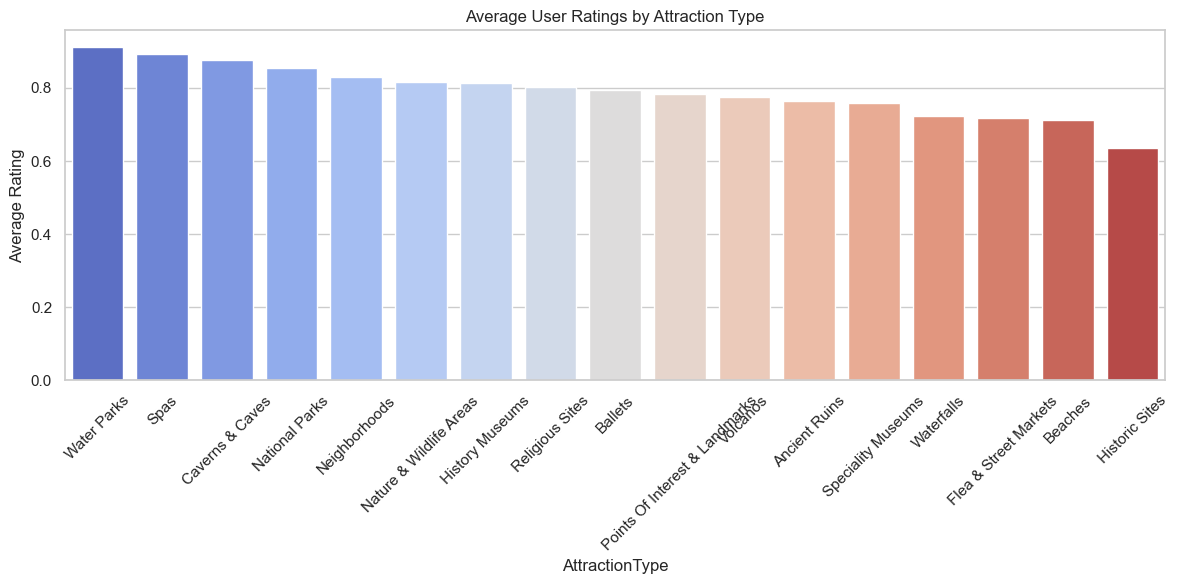

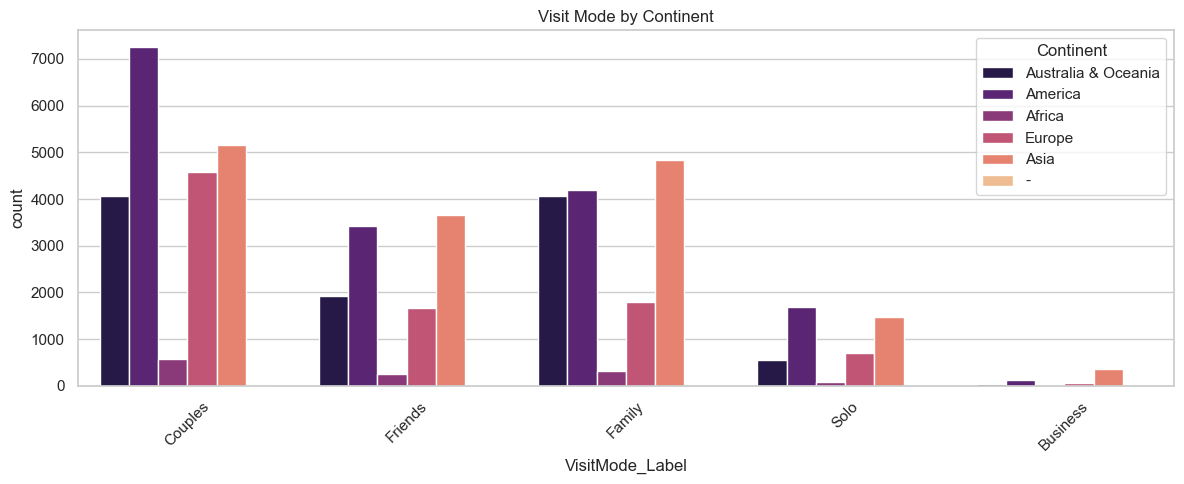

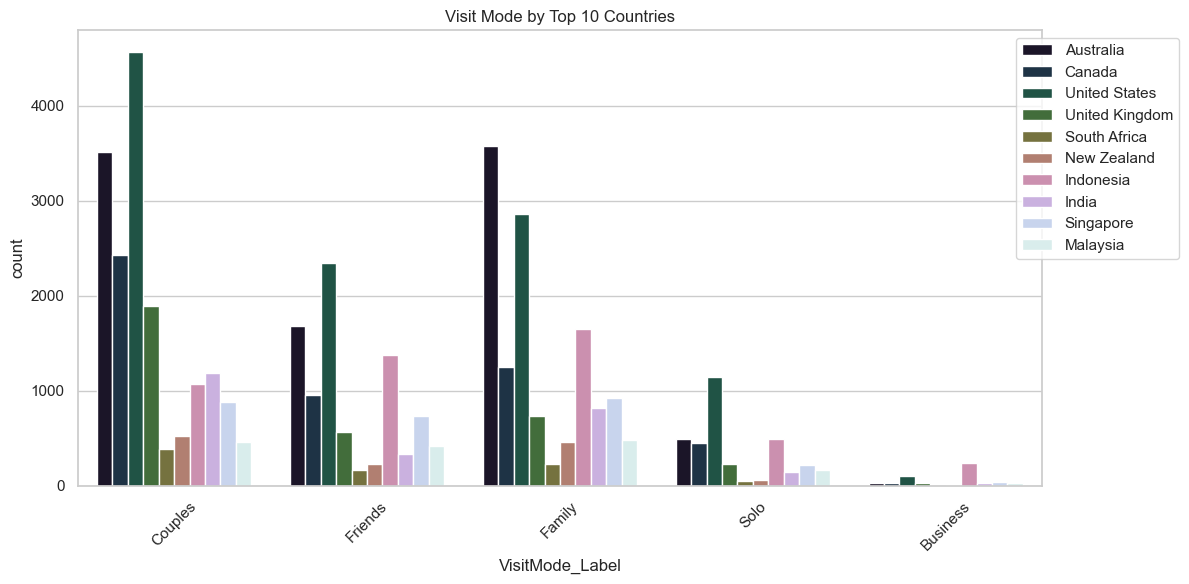

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv(r"D:\Tourism_Experience_Analytics\test123.csv")

# Replace VisitMode with labels
visit_mode_mapping = {
    1: 'Business',
    2: 'Couples',
    3: 'Family',
    4: 'Friends',
    5: 'Solo'
}
df['VisitMode_Label'] = df['VisitMode'].map(visit_mode_mapping)

# Attraction types and their popularity based on user ratings (mean rating barplot)
plt.figure(figsize=(12, 6))
attraction_rating = df.groupby('AttractionType')['Rating_Scaled'].mean().sort_values(ascending=False)
sns.barplot(x=attraction_rating.index, y=attraction_rating.values, palette='coolwarm')
plt.title('Average User Ratings by Attraction Type')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation between VisitMode (labeled) and Continent
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='VisitMode_Label', hue='Continent', palette='magma')
plt.title('Visit Mode by Continent')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Correlation between VisitMode (labeled) and Top 10 Countries
plt.figure(figsize=(12, 6))
top_10_countries = df['Country'].value_counts().head(10).index
filtered_df = df[df['Country'].isin(top_10_countries)]
sns.countplot(data=filtered_df, x='VisitMode_Label', hue='Country', palette='cubehelix')
plt.title('Visit Mode by Top 10 Countries')
plt.xticks(rotation=45)
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
plt.tight_layout()
plt.show()


C:\Users\Ajithkumar\AppData\Local\Temp\ipykernel_14488\1279659201.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=attraction_avg_ratings.index, y=attraction_avg_ratings.values, palette='plasma')


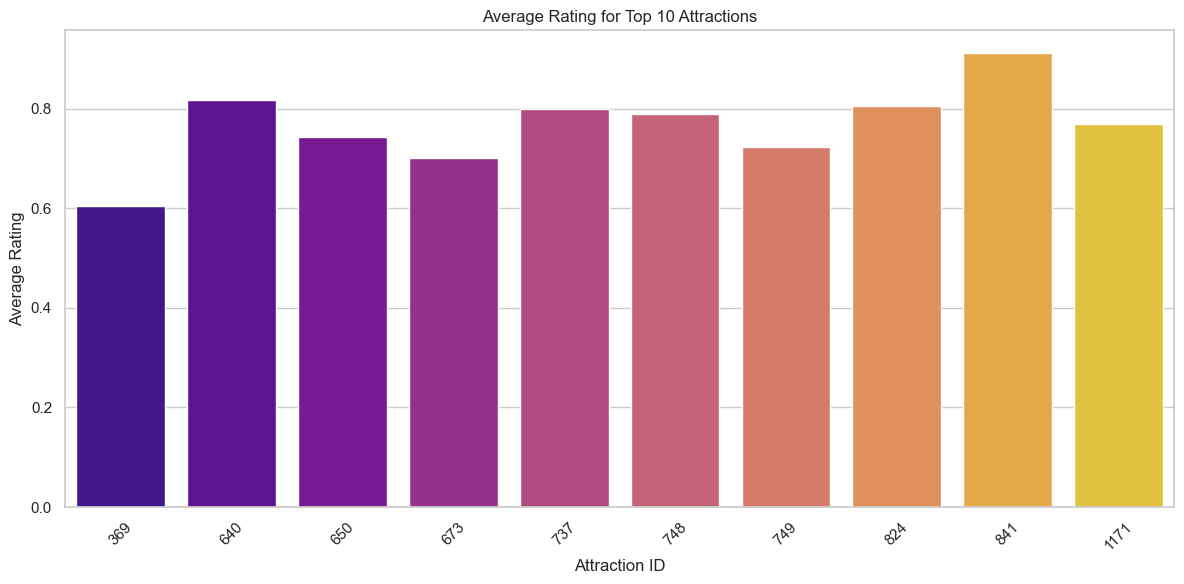

C:\Users\Ajithkumar\AppData\Local\Temp\ipykernel_14488\1279659201.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=country_avg_ratings.index, y=country_avg_ratings.values, palette='Spectral')


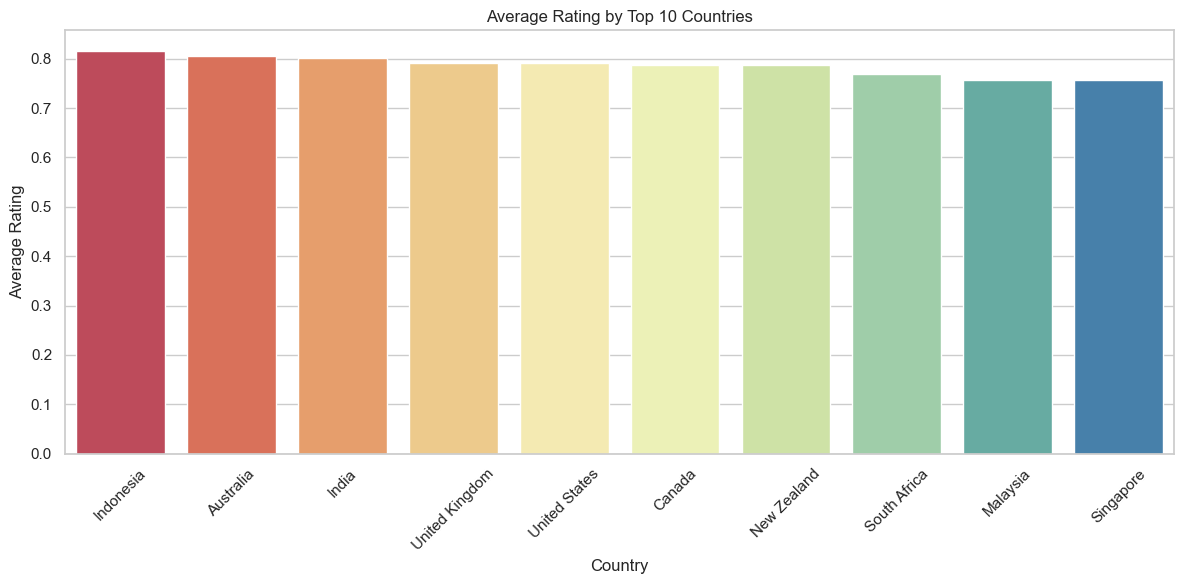

In [10]:


# Average rating for top 10 attractions
plt.figure(figsize=(12, 6))
top_attractions = df['AttractionId'].value_counts().head(10).index
attraction_avg_ratings = df[df['AttractionId'].isin(top_attractions)].groupby('AttractionId')['Rating_Scaled'].mean().sort_values(ascending=False)

sns.barplot(x=attraction_avg_ratings.index, y=attraction_avg_ratings.values, palette='plasma')
plt.title('Average Rating for Top 10 Attractions')
plt.ylabel('Average Rating')
plt.xlabel('Attraction ID')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#Average rating by country (top 10 only for better visibility)
plt.figure(figsize=(12, 6))
top_countries = df['Country'].value_counts().head(10).index
country_avg_ratings = df[df['Country'].isin(top_countries)].groupby('Country')['Rating_Scaled'].mean().sort_values(ascending=False)

sns.barplot(x=country_avg_ratings.index, y=country_avg_ratings.values, palette='Spectral')
plt.title('Average Rating by Top 10 Countries')
plt.ylabel('Average Rating')
plt.xlabel('Country')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Load dataset
df = pd.read_csv("test123.csv")

# Drop rows with missing values
df.dropna(inplace=True)

# Drop identifier columns that shouldn't be used as features
df.drop(columns=["UserId", "AttractionId", "VisitDate"], inplace=True, errors="ignore")

# Define target and features
target = "Rating_Scaled"
X = df.drop(columns=[target])
y = df[target]

# Encode categorical features if any are still non-numeric
for col in X.select_dtypes(include=["object", "category"]).columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)

# Train and predict
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name="Model"):
    print(f"\n{model_name} Evaluation:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")

# Evaluate both models
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest Regressor")



Linear Regression Evaluation:
R² Score: 0.7983
MAE: 0.0542
RMSE: 0.1094

Random Forest Regressor Evaluation:
R² Score: 0.7302
MAE: 0.0623
RMSE: 0.1266


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import OrdinalEncoder
from lightgbm import LGBMRegressor
import joblib

# Load dataset
df = pd.read_csv("test123.csv")

# Drop unnecessary columns
df = df.drop(columns=["UserID", "AttractionID"], errors="ignore")

# Drop rows with missing target
df = df.dropna(subset=["Rating_Scaled"])

# Drop or convert non-numeric columns
if "VisitDate" in df.columns:
    df = df.drop(columns=["VisitDate"])  # Drop if not needed

# Encode categorical variables
cat_cols = df.select_dtypes(include=["object", "category"]).columns
if len(cat_cols) > 0:
    encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
    df[cat_cols] = encoder.fit_transform(df[cat_cols])

# Define features and target
X = df.drop(columns=["Rating_Scaled"])
y = df["Rating_Scaled"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# LightGBM model
lgbm = LGBMRegressor(random_state=42)

# Hyperparameter grid
param_dist = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "num_leaves": [20, 31, 40, 50],
    "max_depth": [-1, 5, 10, 15],
    "min_child_samples": [10, 20, 30],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
}

# Randomized search
random_search = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_dist,
    n_iter=30,
    scoring='r2',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=1  # Safe for now
)

# Fit the model
random_search.fit(X_train, y_train)

# Best model
best_lgbm = random_search.best_estimator_

# Predict
y_pred = best_lgbm.predict(X_test)

# Evaluation
def evaluate_model(y_true, y_pred, name="Model"):
    print(f"\n{name} Evaluation:")
    print(f"R² Score: {r2_score(y_true, y_pred):.4f}")
    print(f"MAE: {mean_absolute_error(y_true, y_pred):.4f}")
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    print(f"RMSE: {rmse:.4f}")

evaluate_model(y_test, y_pred, "LightGBM Regressor (Tuned)")

# Save model
joblib.dump(best_lgbm, "best_lgbm_model.pkl")


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001801 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 790
[LightGBM] [Info] Number of data points in the train set: 28224, number of used features: 16
[LightGBM] [Info] Start training from score 0.787920
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 781
[LightGBM] [Info] Number of data points in the train set: 28225, number of used features: 16
[LightGBM] [Info] Start training from score 0.789247
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 785
[LightGBM] [Info] Number of data points in the train set: 2822

['best_lgbm_model.pkl']

In [6]:
# LightGBM classification

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Copy data
df_class = df.copy()

# Drop target and not-needed features from inputs
X = df_class.drop(columns=[
    "VisitMode", "VisitMode_Encoded", 
    "Rating", "Rating_Scaled", 
    "VisitDate", "Country", "Continent", "AttractionType"
], errors="ignore")

# Target: VisitMode
y = df["VisitMode"]

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Class names for reporting
class_names = [str(cls) for cls in le.classes_]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Base LightGBM classifier
clf = LGBMClassifier(random_state=42)

# Hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, -1],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'num_leaves': [15, 31, 63, 127],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5]
}

# RandomizedSearchCV with n_jobs=1 to avoid BrokenProcessPool
random_search = RandomizedSearchCV(
    clf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=1,
    random_state=42
)

# Fit the model
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predictions
y_pred = best_model.predict(X_test)

# Evaluation
print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000696 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 624
[LightGBM] [Info] Number of data points in the train set: 24696, number of used features: 11
[LightGBM] [Info] Start training from score -4.444516
[LightGBM] [Info] Start training from score -0.895295
[LightGBM] [Info] Start training from score -1.246547
[LightGBM] [Info] Start training from score -1.576029
[LightGBM] [Info] Start training from score -2.459480
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 623
[LightGBM] [Info] Number of data points in the train set: 24697, number of used features: 11
[LightGBM] [Info] Start train

In [7]:
# Reprint all metrics clearly
print("Best Parameters:\n", random_search.best_params_)

print("\nAccuracy on Test Set: {:.4f}".format(accuracy_score(y_test, y_pred)))

print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=class_names))

print("\nConfusion Matrix:\n")
print(pd.DataFrame(confusion_matrix(y_test, y_pred), 
                   index=[f"Actual_{cls}" for cls in class_names], 
                   columns=[f"Pred_{cls}" for cls in class_names]))


Best Parameters:
 {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0, 'num_leaves': 127, 'n_estimators': 200, 'max_depth': 15, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Accuracy on Test Set: 0.5486

Classification Report:

              precision    recall  f1-score   support

           1       0.55      0.25      0.35       187
           2       0.55      0.77      0.64      6485
           3       0.57      0.52      0.55      4565
           4       0.50      0.31      0.38      3283
           5       0.61      0.20      0.31      1357

    accuracy                           0.55     15877
   macro avg       0.56      0.41      0.44     15877
weighted avg       0.55      0.55      0.53     15877


Confusion Matrix:

          Pred_1  Pred_2  Pred_3  Pred_4  Pred_5
Actual_1      47      65      35      38       2
Actual_2       9    4991     951     465      69
Actual_3      11    1769    2380     350      55
Actual_4      12    1593     612    1016      50
Actual_5       

In [8]:
#Random forest classification

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Copy data
df_class = df.copy()

# Drop target and not-needed features from inputs
X = df_class.drop(columns=[
    "VisitMode", "VisitMode_Encoded", 
    "Rating", "Rating_Scaled", 
    "VisitDate", "Country", "Continent", "AttractionType"
], errors="ignore")

# Target: VisitMode
y = df["VisitMode"]

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Class names for reporting
class_names = [str(cls) for cls in le.classes_]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Base Random Forest classifier
rf = RandomForestClassifier(class_weight='balanced', random_state=42)

# Hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

# RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=30,
    scoring='f1_macro',  # Better metric for imbalanced classification
    cv=3,
    verbose=1,
    n_jobs=1,
    random_state=42
)

# Fit the model
random_search_rf.fit(X_train, y_train)

# Best model
best_rf_model = random_search_rf.best_estimator_

# Predict on test set
y_pred = best_rf_model.predict(X_test)

# Evaluation
print("Best Parameters:", random_search_rf.best_params_)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))
print("\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, y_pred), 
                                            index=[f"Actual_{c}" for c in class_names], 
                                            columns=[f"Pred_{c}" for c in class_names]))


Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\Ajithkumar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py:528: FitFailedWarning: 
30 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Ajithkumar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Ajithkumar\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~^

Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20}
Accuracy on Test Set: 0.4752157208540656

Classification Report:
               precision    recall  f1-score   support

           1       0.16      0.24      0.19       187
           2       0.55      0.58      0.57      6485
           3       0.51      0.48      0.50      4565
           4       0.37      0.34      0.36      3283
           5       0.28      0.30      0.29      1357

    accuracy                           0.48     15877
   macro avg       0.37      0.39      0.38     15877
weighted avg       0.48      0.48      0.48     15877


Confusion Matrix:
           Pred_1  Pred_2  Pred_3  Pred_4  Pred_5
Actual_1      45      49      40      43      10
Actual_2      80    3755    1166     972     512
Actual_3      83    1326    2210     666     280
Actual_4      58    1157     675    1130     263
Actual_5      24     479     218     231     405


In [4]:
#XGB Booster

import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Prepare data
df_class = df.copy()

# Drop target and unrelated features
X = df_class.drop(columns=[
    "VisitMode", "VisitMode_Encoded", 
    "Rating", "Rating_Scaled", 
    "VisitDate", "Country", "Continent", "AttractionType"
], errors="ignore")

y = df["VisitMode"]

# Encode target labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = [str(cls) for cls in le.classes_]  # Convert to string to avoid TypeError

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

# Base XGBoost model
xgb = XGBClassifier(
    objective='multi:softmax',
    num_class=len(class_names),
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42
)

# Simplified hyperparameter space to speed up search
param_dist = {
    'n_estimators': [100, 150],
    'max_depth': [5, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Randomized search
random_search = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    n_iter=10,  # reduced for speed
    scoring='accuracy',
    cv=3,
    verbose=1,
    n_jobs=1,  # for Windows compatibility
    random_state=42
)

# Train model
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

# Predict
y_pred = best_model.predict(X_test)

# Evaluation
print("Best Parameters:", random_search.best_params_)
print("Accuracy on Test Set:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=class_names))
print("\nConfusion Matrix:\n", pd.crosstab(y_test, y_pred, rownames=['Actual'], colnames=['Predicted']))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\Ajithkumar\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:38:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Ajithkumar\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:38:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Ajithkumar\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:38:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label

Best Parameters: {'subsample': 0.8, 'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Accuracy on Test Set: 0.5536940228002771

Classification Report:
               precision    recall  f1-score   support

           1       0.70      0.22      0.34       187
           2       0.55      0.79      0.65      6485
           3       0.57      0.52      0.55      4565
           4       0.51      0.31      0.38      3283
           5       0.63      0.19      0.29      1357

    accuracy                           0.55     15877
   macro avg       0.59      0.41      0.44     15877
weighted avg       0.56      0.55      0.53     15877


Confusion Matrix:
 Predicted   0     1     2     3    4
Actual                              
0          42    64    42    36    3
1           5  5100   906   415   59
2           3  1770  2389   361   42
3           6  1577   647  1005   48
4           4   721   213   164  255


In [ ]:
import joblib

# Save model
joblib.dump(best_model, "classification_xgb_visitmode_model.pkl")

# Save label encoder
joblib.dump(le, "classification_visitmode_label_encoder.pkl")

# Save feature column names (so Streamlit app uses same structure)
joblib.dump(list(X.columns), "classification_feature_columns.pkl")

print("Model, label encoder, and feature list saved for Streamlit.")


✅ Model, label encoder, and feature list saved for Streamlit.


In [ ]:
#Collabrative_filter_reccomendation
import pandas as pd
import numpy as np
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load data
df = pd.read_csv("D:/Tourism_Experience_Analytics/test123.csv")

# Select relevant columns
df = df[['UserId', 'AttractionId', 'Rating_Scaled']]

# Create the user-item matrix
user_item_matrix = df.pivot_table(index='UserId', columns='AttractionId', values='Rating_Scaled').fillna(0)

# Apply Truncated SVD
n_components = 20
svd = TruncatedSVD(n_components=n_components, random_state=42)
svd_matrix = svd.fit_transform(user_item_matrix)

# Reconstruct predicted rating matrix
predicted_matrix = np.dot(svd_matrix, svd.components_)

# Flatten values for metric calculation
actual = user_item_matrix.values.flatten()
predicted = predicted_matrix.flatten()

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(actual, predicted))
mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
r2 = r2_score(actual, predicted)

print("Model Evaluation Metrics")
print("------------------------")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"R²  : {r2:.4f}")

# Recommend attractions for a user by row position (iloc)
def recommend_attractions_by_row_index(row_index, top_n=5):
    attraction_ids = user_item_matrix.columns

    # Get actual and predicted ratings using row index
    actual_ratings = user_item_matrix.iloc[row_index]
    predicted_ratings = predicted_matrix[row_index]

    # Find unrated attractions
    unrated_mask = actual_ratings == 0
    recommendations = [
        (attraction_ids[i], predicted_ratings[i])
        for i in range(len(attraction_ids)) if unrated_mask.iloc[i]
    ]

    # Sort recommendations by predicted score
    recommendations.sort(key=lambda x: x[1], reverse=True)

    user_label = user_item_matrix.index[row_index]
    print(f"\nTop {top_n} recommended attractions for user '{user_label}':")
    for idx, (attr_id, score) in enumerate(recommendations[:top_n], 1):
        print(f"{idx}. Attraction ID: {attr_id}, Predicted Rating: {score:.3f}")

# Example: Recommend for first user in matrix
recommend_attractions_by_row_index(row_index=0, top_n=5)


Model Evaluation Metrics
------------------------
RMSE: 0.0185
MAE : 0.0007
MSE : 0.0003
R²  : 0.9884

Top 5 recommended attractions for user '14':
1. Attraction ID: 897, Predicted Rating: 0.001
2. Attraction ID: 913, Predicted Rating: 0.000
3. Attraction ID: 975, Predicted Rating: 0.000
4. Attraction ID: 1137, Predicted Rating: 0.000
5. Attraction ID: 877, Predicted Rating: 0.000


In [ ]:
#saving collabrative model training file
import joblib

joblib.dump(svd, 'D:/Tourism_Experience_Analytics/streamlit/collab_model.pkl')
print("Model saved successfully.")


Model saved successfully.


In [ ]:
#Content based filter recommendation
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score

# Load data
df = pd.read_csv("D:/Tourism_Experience_Analytics/test123.csv")

# Drop missing values
df.dropna(subset=['UserId', 'AttractionId', 'AttractionType', 'AttractionCityId', 'Country', 'Continent'], inplace=True)

# Create a content string per attraction
df['content'] = (
    df['AttractionType'].astype(str) + " " +
    df['AttractionCityId'].astype(str) + " " +
    df['Country'].astype(str) + " " +
    df['Continent'].astype(str)
)

# Drop duplicate attractions
attractions = df.drop_duplicates(subset='AttractionId')[['AttractionId', 'content']]

# TF-IDF vectorization
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(attractions['content'])

# Cosine similarity matrix
similarity = cosine_similarity(tfidf_matrix)

# Index mappings
attraction_id_to_index = {aid: idx for idx, aid in enumerate(attractions['AttractionId'])}
index_to_attraction_id = pd.Series(attractions['AttractionId'].values)

# Calculate popularity
popularity = df['AttractionId'].value_counts(normalize=True)
popularity_vector = np.array([popularity.get(aid, 0) for aid in index_to_attraction_id])

# Evaluate
users = df['UserId'].unique()
k = 5

actual, predicted = [], []
evaluated_users = 0

for user in users:
    user_data = df[df['UserId'] == user]['AttractionId'].tolist()
    if len(user_data) < 2:
        continue
    
    train_ids, test_ids = user_data[:-1], [user_data[-1]]
    
    sim_scores = np.zeros(similarity.shape[0])
    weights = np.linspace(1.0, 0.5, len(train_ids))
    
    for i, aid in enumerate(train_ids):
        idx = attraction_id_to_index.get(aid)
        if idx is not None and idx < similarity.shape[0]:
            sim_scores += similarity[idx] * weights[i]

    # Apply popularity boosting
    alpha = 0.8
    sim_scores = alpha * sim_scores + (1 - alpha) * popularity_vector

    # Exclude already visited
    visited_indices = [attraction_id_to_index[aid] for aid in train_ids if aid in attraction_id_to_index]
    sim_scores[visited_indices] = -1

    # Top-k recommendations
    top_indices = sim_scores.argsort()[::-1][:k]
    top_attraction_ids = index_to_attraction_id.iloc[top_indices].tolist()

    actual.append(test_ids)
    predicted.append(top_attraction_ids)
    evaluated_users += 1

# Evaluation metrics
precision, recall, f1, ap_total = [], [], [], []

for a, p in zip(actual, predicted):
    a_set, p_set = set(a), set(p)
    intersection = a_set & p_set
    
    prec = len(intersection) / len(p_set) if p_set else 0
    rec = len(intersection) / len(a_set) if a_set else 0
    f1_score_val = 2 * prec * rec / (prec + rec) if prec + rec > 0 else 0

    # MAP@k
    ap = 0
    hits = 0
    for idx, item in enumerate(p):
        if item in a:
            hits += 1
            ap += hits / (idx + 1)

    ap_total.append(ap / len(a) if a else 0)
    
    precision.append(prec)
    recall.append(rec)
    f1.append(f1_score_val)

# Final results
print(f"Users evaluated: {evaluated_users}")
print(f"Precision@{k}: {np.mean(precision):.4f}")
print(f"Recall@{k}: {np.mean(recall):.4f}")
print(f"F1@{k}: {np.mean(f1):.4f}")
print(f"MAP@{k}: {np.mean(ap_total):.4f}")


Users evaluated: 10615
Precision@5: 0.0612
Recall@5: 0.3058
F1@5: 0.1019
MAP@5: 0.1179


In [ ]:
#Saving content based filter recommendation
import pickle

model_data = {
    "similarity": similarity,
    "attraction_id_to_index": attraction_id_to_index,
    "index_to_attraction_id": index_to_attraction_id,
    "popularity_vector": popularity_vector
}

with open("D:/Tourism_Experience_Analytics/streamlit/content_model.pkl", "wb") as f:
    pickle.dump(model_data, f)

print("Model saved successfully.")


✅ Model saved successfully.
